# Visual Odometry for Localization in Autonomous Driving

Welcome to the assignment for Module 2: Visual Features - Detection, Description and Matching. In this assignment, you will practice using the material you have learned to estimate an autonomous vehicle trajectory by images taken with a monocular camera set up on the vehicle.


**In this assignment, you will:**
- Extract  features from the photographs  taken with a camera setup on the vehicle.
- Use the extracted features to find matches between the features in different photographs.
- Use the found matches to estimate the camera motion between subsequent photographs. 
- Use the estimated camera motion to build the vehicle trajectory.

For most exercises, you are provided with a suggested outline. You are encouraged to diverge from the outline if you think there is a better, more efficient way to solve a problem.

You are only allowed to use the packages loaded bellow and the custom functions explained in the notebook. Run the cell bellow to import the required packages:

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from m2bk import *
import time
from tqdm import tqdm
import open3d as o3d

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(1)
#np.set_printoptions(threshold=np.nan)
np.set_printoptions(threshold=np.inf, linewidth=np.nan)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## 0 - Loading and Visualizing the Data
We provide you with a convenient dataset handler class to read and iterate through samples taken from the CARLA simulator. Run the following code to create a dataset handler object. 

In [3]:
dataset_handler = DatasetHandler()

The dataset handler contains 52 data frames. Each frame contains an RGB image and a depth map taken with a setup on the vehicle and a grayscale version of the RGB image which will be used for computation. Furthermore, camera calibration matrix K is also provided in the dataset handler.

Upon creation of the dataset handler object, all the frames will be automatically read and loaded. The frame content can be accessed by using `images`, `images_rgb`, `depth_maps` attributes of the dataset handler object along with the index of the requested frame. See how to access the images (grayscale), rgb images (3-channel color), depth maps and camera calibration matrix in the example below.

**Note (Depth Maps)**: Maximum depth distance is 1000. This value of depth shows that the selected pixel is at least 1000m (1km) far from the camera, however the exact distance of this pixel from the camera is unknown. Having this kind of points in further trajectory estimation might affect the trajectory precision.

gray image: ((960, 1280), dtype('uint8'))
rgb image: ((960, 1280, 3), dtype('uint8'))
depth image: ((960, 1280), dtype('float64'))


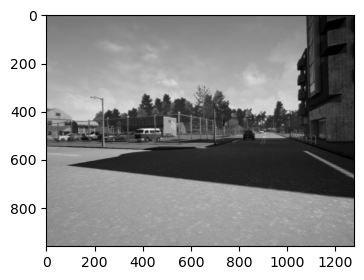

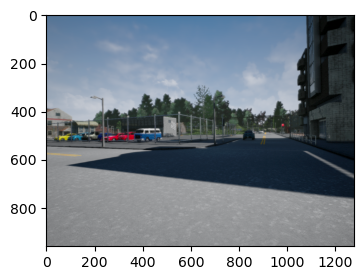

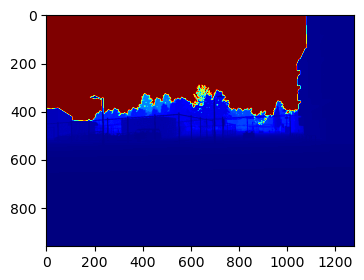

In [4]:
i = 0

# gray
image = dataset_handler.images[i]
print(f"gray image: {image.shape, image.dtype}")
plt.figure(figsize=(4, 3), dpi=100)
plt.imshow(image, cmap='gray')

# rgb
image_rgb = dataset_handler.images_rgb[i]
print(f"rgb image: {image_rgb.shape, image_rgb.dtype}")
plt.figure(figsize=(4, 3), dpi=100)
plt.imshow(image_rgb)

# depth
depth = dataset_handler.depth_maps[i]
print(f"depth image: {depth.shape, depth.dtype}")
plt.figure(figsize=(4, 3), dpi=100)
plt.imshow(depth, cmap='jet')
#plt.colorbar()

del i, image, image_rgb, depth

(array([778581.,  37250.,   7843.,      0.,      0.,      0.,      0.,      0.,      0., 405126.]),
 array([   1.862 ,  101.6758,  201.4896,  301.3034,  401.1172,  500.931 ,  600.7448,  700.5586,  800.3724,  900.1862, 1000.    ]),
 <BarContainer object of 10 artists>)

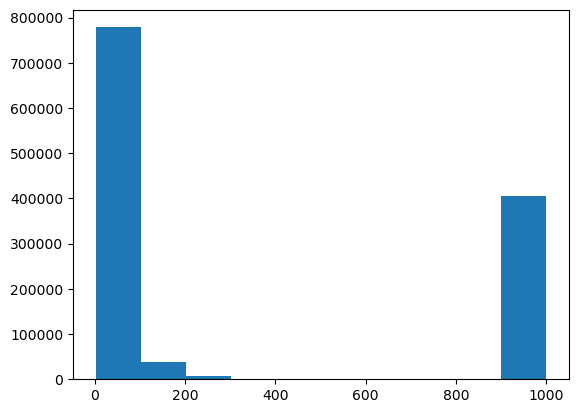

In [5]:
plt.hist(dataset_handler.depth_maps[0].flatten())

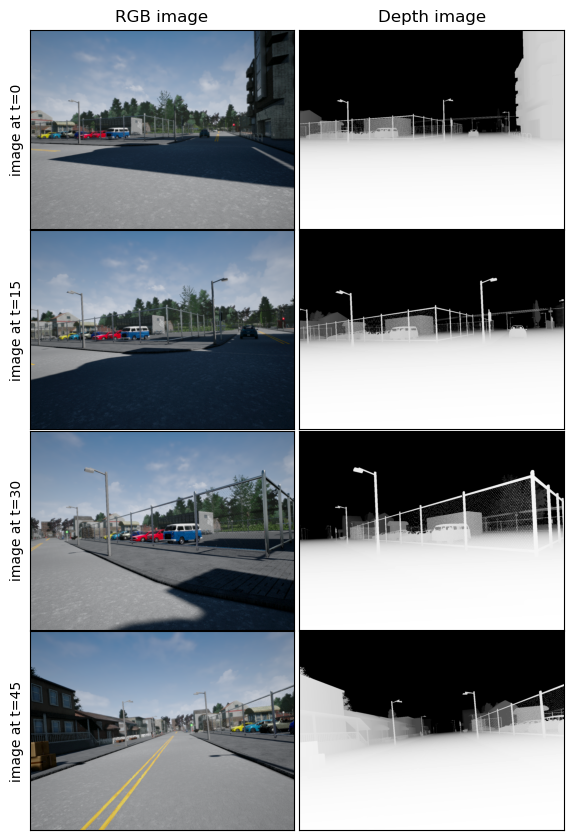

In [6]:
# Code to print rgb images with frame title
# rgb
ids = [0, 15, 30, 45]
fig, axs = plt.subplots(len(ids),2, figsize=(12,8))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=-0.71, hspace=0.01)
for i, id in enumerate(ids):
    axs[i,0].set_ylabel(f"image at t={id}")
    axs[i,0].set_xticks([])
    axs[i,0].set_yticks([])    
    axs[i,0].imshow(dataset_handler.images_rgb[id])
    axs[i,1].set_xticks([])
    axs[i,1].set_yticks([])
    dep_img = dataset_handler.depth_maps[id]
    dep_img[dep_img > 80] = 80
    axs[i,1].imshow(1-dep_img, cmap="gray")
axs[0,0].set_title('RGB image')
axs[0,1].set_title('Depth image')
plt.show()

In [7]:
print(dataset_handler.k)
K_FX = dataset_handler.k[0,0]
K_FY = dataset_handler.k[1,1]
K_CX = dataset_handler.k[0,2]
K_CY = dataset_handler.k[1,2]

[[640.   0. 640.]
 [  0. 480. 480.]
 [  0.   0.   1.]]


In order to access an arbitrary frame use image index, as shown in the examples below. Make sure the indexes are within the number of frames in the dataset. The number of frames in the dataset can be accessed with num_frames attribute.

## 1 - Feature Extraction

### 1.1 - Extracting Features from an Image

**Task**: Implement feature extraction from a single image. You can use any feature descriptor of your choice covered in the lectures, ORB for example. 


Note 1: Make sure you understand the structure of the keypoint descriptor object, this will be very useful for your further tasks. You might find [OpenCV: Keypoint Class Description](https://docs.opencv.org/3.4.3/d2/d29/classcv_1_1KeyPoint.html) handy.

Note 2: Make sure you understand the image coordinate system, namely the origin location and axis directions.

Note 3: We provide you with a function to visualise the features detected. Run the last 2 cells in section 1.1 to view.

***Optional***: Try to extract features with different descriptors such as SIFT, ORB, SURF and BRIEF. You can also try using detectors such as Harris corners or FAST and pairing them with a descriptor. Lastly, try changing parameters of the algorithms. Do you see the difference in various approaches?
You might find this link useful:  [OpenCV:Feature Detection and Description](https://docs.opencv.org/3.4.3/db/d27/tutorial_py_table_of_contents_feature2d.html). 

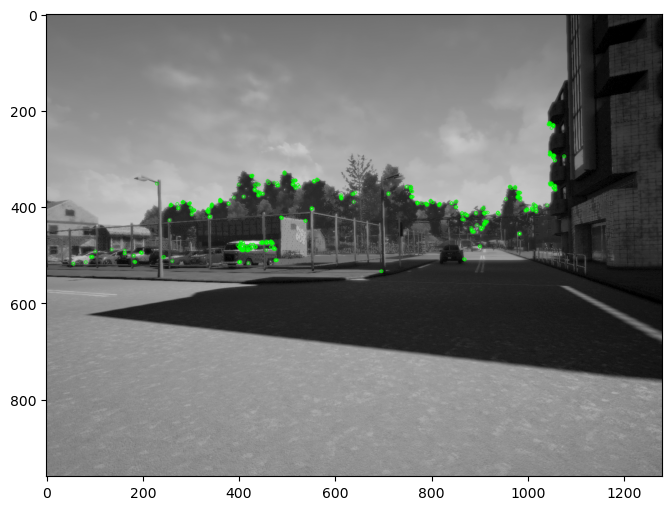

In [8]:
def extract_features_ORB(image: np.ndarray):
    # Documentation: https://docs.opencv.org/3.4.3/db/d95/classcv_1_1ORB.html
    assert len(image.shape) == 2
    assert image.dtype == np.uint8
    
    orb = cv2.ORB_create()
    # find the keypoints with ORB
    kp = orb.detect(image, None)
    # compute the descriptors with ORB
    kp, des = orb.compute(image, kp)
    return kp, des

# Unit test
gray_img = dataset_handler.images[0]
kp, des = extract_features_ORB(gray_img)
gray_img = cv.drawKeypoints(gray_img, kp, None, color=(0,255,0), flags=0)
plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(gray_img)
plt.show()
del gray_img, kp, des

There are 8519 keypoints in the image


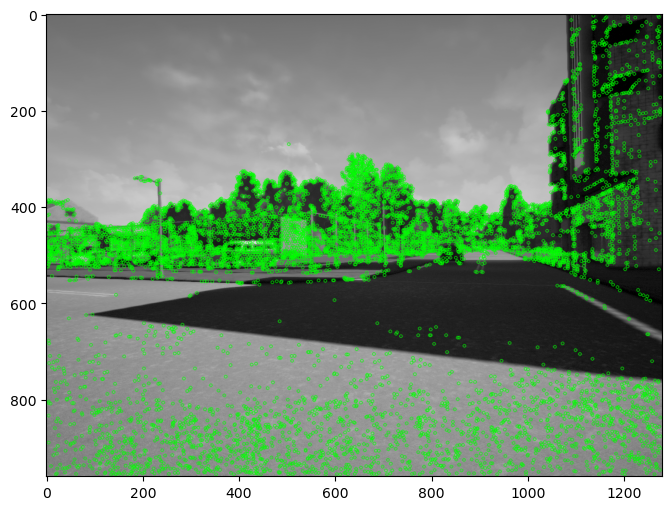

In [9]:
def extract_features_FAST(img: np.ndarray):
    # Documentation: https://docs.opencv.org/3.4.3/df/dd2/tutorial_py_surf_intro.html
    assert len(img.shape) == 2
    assert img.dtype == np.uint8    
    fast = cv2.FastFeatureDetector_create()
    kp = fast.detect(img,None)
    return kp, None

# Unit test
gray_img = dataset_handler.images[0]
kp, des = extract_features_FAST(gray_img)
gray_img = cv.drawKeypoints(gray_img, kp, None, color=(0,255,0), flags=0)
print(f"There are {len(kp)} keypoints in the image")
plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(gray_img)
plt.show()
del gray_img, kp, des

In [10]:
def extract_features(image: np.ndarray, method: str = "orb"):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image (H, W), type uint8

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    ### START CODE HERE ### 
    assert len(image.shape) == 2
    assert image.dtype == np.uint8

    kp, des = None, None

    if method == "orb":
        kp, des = extract_features_ORB(image)
    elif method == "fast":
        kp, des = extract_features_FAST(image)
    else:
        raise Exception("Method not found")
    
    ### END CODE HERE ###
    
    return kp, des

In [11]:
def visualize_features(image, kp):
    """
    Visualize extracted features in the image

    Arguments:
    image -- a grayscale image
    kp -- list of the extracted keypoints
    """
    display = cv2.drawKeypoints(image, kp, None, color=(0,255,0), flags=0)
    plt.imshow(display)
    plt.show()

Meth od: orb, # KP = 500, Time: 0.01 [s]


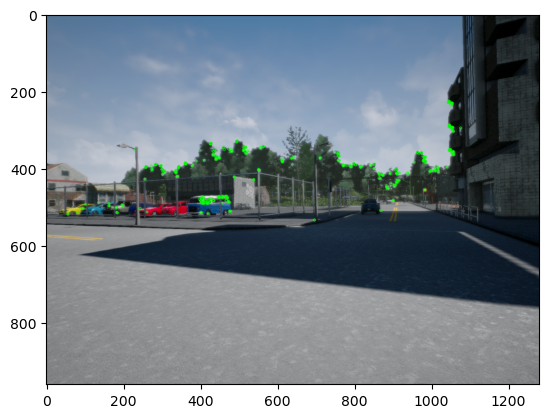

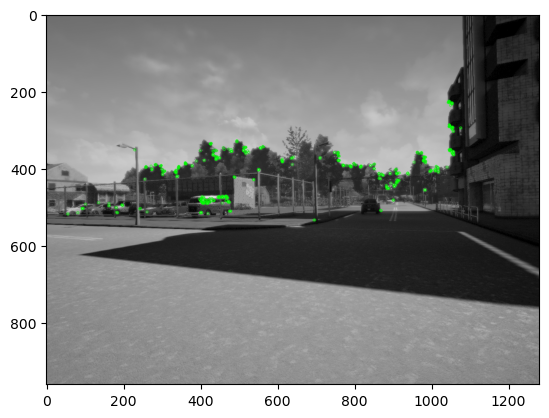

Method: fast, # KP = 8519, Time: 0.0 [s]


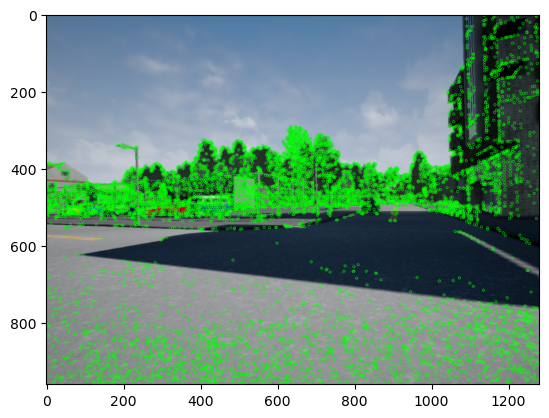

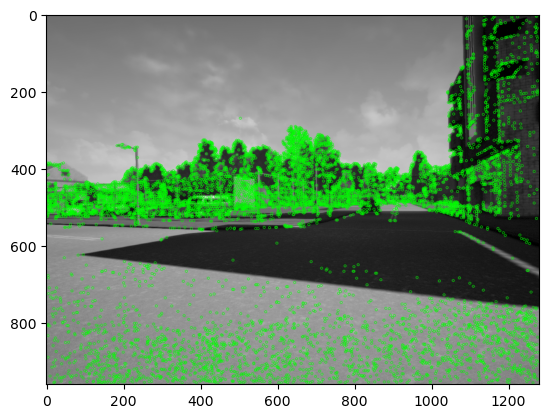

In [12]:
# Optional: visualizing and experimenting with various feature descriptors
i = 0
image_rgb = dataset_handler.images_rgb[i]
image_gray = dataset_handler.images[i]
METHOD = "orb"
start = time.time()
kp, _ = extract_features(image_gray, method=METHOD)
end = time.time()
seconds = round((end - start),2)
print(f"Meth od: {METHOD}, # KP = {len(kp)}, Time: {seconds} [s]")
visualize_features(image_rgb, kp)
visualize_features(image_gray, kp)

METHOD = "fast"
start = time.time()
kp, _ = extract_features(image_gray, method=METHOD)
end = time.time()
seconds = round((end - start),2)
print(f"Method: {METHOD}, # KP = {len(kp)}, Time: {seconds} [s]")
visualize_features(image_rgb, kp)
visualize_features(image_gray, kp)


del i, image_rgb, image_gray, METHOD, start, kp, _, end, seconds

### 1.2 - Extracting Features from Each Image in the Dataset

**Task**: Implement feature extraction for each image in the dataset with the function you wrote in the above section. 

**Note**: If you do not remember how to pass functions as arguments, make sure to brush up on this topic. This [
Passing Functions as Arguments](https://www.coursera.org/lecture/program-code/passing-functions-as-arguments-hnmqD) might be helpful.

In [13]:
def extract_features_dataset(images, extract_features_function):
    """
    Find keypoints and descriptors for each image in the dataset

    Arguments:
    images -- a list of grayscale images
    extract_features_function -- a function which finds features (keypoints and descriptors) for an image

    Returns:
    kp_list -- a list of keypoints for each image in images
    des_list -- a list of descriptors for each image in images
    
    """
    kp_list = []
    des_list = []
    
    ### START CODE HERE ###
    for i in tqdm(images):
        kp, des = extract_features_function(i)
        kp_list.append(kp)
        des_list.append(des)
    ### END CODE HERE ###
    
    return kp_list, des_list

# Unit test
KP_LIST, DESCRIPTOR_LIST = extract_features_dataset(dataset_handler.images, extract_features)
for i, kp in enumerate(KP_LIST):
    print(f"Image {i} has {len(kp)} keypoints")
del i, kp

100%|██████████| 52/52 [00:00<00:00, 81.51it/s]

Image 0 has 500 keypoints
Image 1 has 500 keypoints
Image 2 has 500 keypoints
Image 3 has 500 keypoints
Image 4 has 500 keypoints
Image 5 has 500 keypoints
Image 6 has 500 keypoints
Image 7 has 500 keypoints
Image 8 has 500 keypoints
Image 9 has 500 keypoints
Image 10 has 500 keypoints
Image 11 has 500 keypoints
Image 12 has 500 keypoints
Image 13 has 500 keypoints
Image 14 has 500 keypoints
Image 15 has 500 keypoints
Image 16 has 500 keypoints
Image 17 has 500 keypoints
Image 18 has 500 keypoints
Image 19 has 500 keypoints
Image 20 has 500 keypoints
Image 21 has 500 keypoints
Image 22 has 500 keypoints
Image 23 has 500 keypoints
Image 24 has 500 keypoints
Image 25 has 500 keypoints
Image 26 has 500 keypoints
Image 27 has 500 keypoints
Image 28 has 500 keypoints
Image 29 has 500 keypoints
Image 30 has 500 keypoints
Image 31 has 500 keypoints
Image 32 has 500 keypoints
Image 33 has 500 keypoints
Image 34 has 500 keypoints
Image 35 has 500 keypoints
Image 36 has 500 keypoints
Image 37 ha

## 2 - Feature Matching

Next step after extracting the features in each image is matching the features from the subsequent frames. This is what is needed to be done in this section.

### 2.1 - Matching Features from a Pair of Subsequent Frames

**Task**: Implement feature matching for a pair of images. You can use any feature matching algorithm of your choice covered in the lectures, Brute Force Matching or FLANN based Matching for example.

***Optional 1***: Implement match filtering by thresholding the distance between the best matches. This might be useful for improving your overall trajectory estimation results. Recall that you have an option of specifying the number best matches to be returned by the matcher.

We have provided a visualization of the found matches. Do all the matches look legitimate to you? Do you think match filtering can improve the situation?

In [14]:
def visualize_matches(image1, kp1, image2, kp2, match, title="", min_distance=0, max_distance=np.inf):
    """
    Visualize corresponding matches in two images
    # source: https://docs.opencv.org/4.x/d4/d5d/group__features2d__draw.html
    # https://docs.opencv.org/4.x/d4/d5d/group__features2d__draw.html#gad8f463ccaf0dc6f61083abd8717c261a

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images
    matchesMask -- Mask determining which matches are drawn. If the mask is empty, all matches are drawn. (1 or 0)

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """    
    mask = [1 if min_distance <= m.distance <= max_distance else 0 for m in match]
    image_matches = cv2.drawMatches(image1, 
                                    kp1, 
                                    image2, 
                                    kp2, 
                                    match, 
                                    None, 
                                    matchColor=(0,255,0), 
                                    singlePointColor=(255,0,0),
                                    matchesMask = mask,
                                    flags=cv.DRAW_MATCHES_FLAGS_DEFAULT)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.title(title)
    plt.imshow(image_matches)
    plt.show()

There are 223 matches, # kp in images: (500, 500)


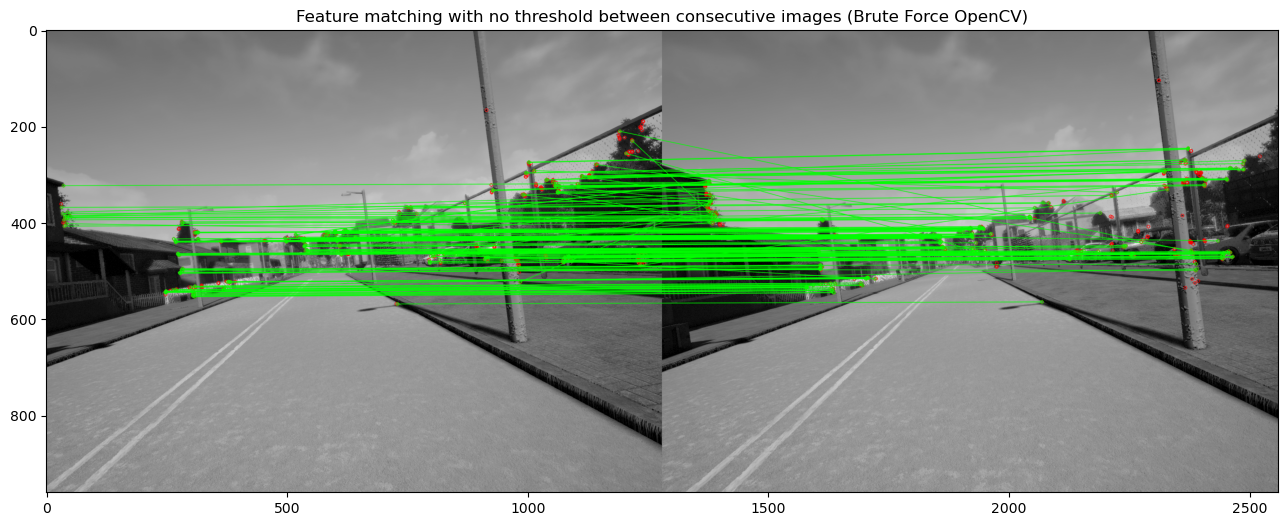

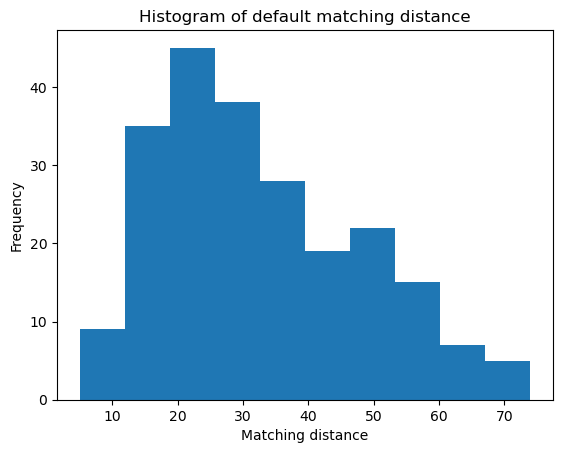

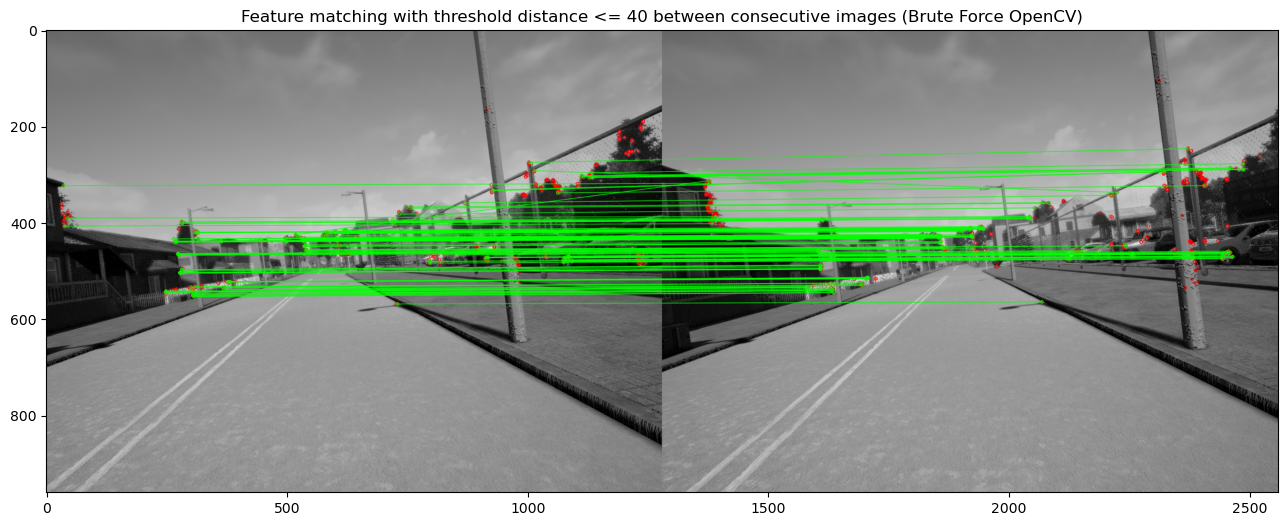

In [15]:
def match_features(des1, des2, max_distance=40, method="brute"):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image
    max_distance -- max distance in the matching

    Returns:
    match -- list of matched features from two images. Each match[i] is k or less matches for the same query descriptor
    The result of matches = bf.match(des1,des2) line is a list of DMatch objects. This DMatch object has following attributes:
        DMatch.distance - Distance between descriptors. The lower, the better it is.
        DMatch.trainIdx - Index of the descriptor in train descriptors
        DMatch.queryIdx - Index of the descriptor in query descriptors
        DMatch.imgIdx - Index of the train image.
    """
    ### START CODE HERE ###
    matches = None

    if method == "brute":
        # create BFMatcher object
        bf = cv.BFMatcher.create(cv.NORM_HAMMING, crossCheck=True)
        # Match descriptors.
        matches = bf.match(des1,des2)
        # Sort them in the order of their distance.
        matches = sorted(matches, key = lambda x:x.distance)

    if max_distance:
        matches = [m for m in matches if m.distance <= max_distance]
    ### END CODE HERE ###
    return matches

# Unit test
# Remember that a matcher finds the best matches for EACH descriptor from a query set
i = 40
image1 = dataset_handler.images[i]
image2 = dataset_handler.images[i+1]
kp1 = KP_LIST[i]
kp2 = KP_LIST[i+1]
match = match_features(DESCRIPTOR_LIST[i], DESCRIPTOR_LIST[i+1], max_distance=99999999)
distances = [m.distance for m in match]
print(f"There are {len(match)} matches, # kp in images: {len(kp1),len(kp2)}")
#print(f"Min distance: {min(distances)}")
#print(f"Avg distance: {np.average(distances)}")
#print(f"Min distance: {max(distances)}")

# Checkout the indices of keypoints matched
for i, m in enumerate(match):
    x1 = int(kp1[m.queryIdx].pt[0])
    y1 = int(kp1[m.queryIdx].pt[1])
    x2 = int(kp2[m.trainIdx].pt[0])
    y2 = int(kp2[m.trainIdx].pt[1])
    #print(f"i={i} -> distance: {m.distance}, p1: {x1,y1}, p2: {x2,y2}")

# Visualize the match
visualize_matches(image1, kp1, image2, kp2, match, title="Feature matching with no threshold between consecutive images (Brute Force OpenCV)")

# Check out the distances
plt.hist(distances)
plt.title("Histogram of default matching distance")
plt.xlabel('Matching distance')
plt.ylabel('Frequency')
plt.show

visualize_matches(image1, kp1, image2, kp2, match, title="Feature matching with threshold distance <= 40 between consecutive images (Brute Force OpenCV)", max_distance=40)

del i, m, image1, image2, kp1, kp2, match, x1, y1, x2, y2

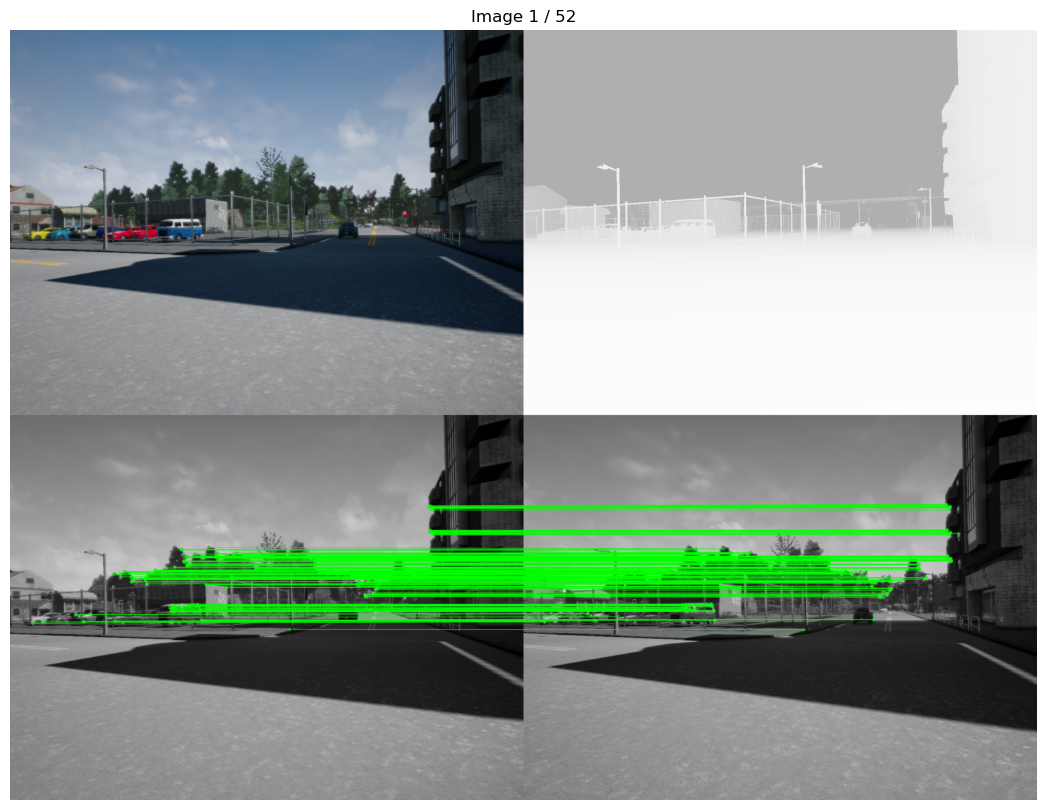

In [17]:
# Code to print the images so that we can make a movie afterwards
for i in [0]:
    image1 = dataset_handler.images[i]
    image2 = dataset_handler.images[i+1]
    kp1 = KP_LIST[i]
    kp2 = KP_LIST[i+1]
    match = match_features(DESCRIPTOR_LIST[i], DESCRIPTOR_LIST[i+1], max_distance=40)
    image_rgb = dataset_handler.images_rgb[i]
    depth1 = dataset_handler.depth_maps[i]
    #depth1[depth1 == 1000] = 500

    H,W = image1.shape
    full_image = np.zeros((2*H, 2*W, 3), dtype=image1.dtype)
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, matchColor=(0,255,0), singlePointColor=(255,0,0), flags=cv.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
    full_image[H:, :, :] = image_matches
    full_image[0:H, 0:W, :] = image_rgb
    full_image[0:H, W:, 0] = 255-depth1
    full_image[0:H, W:, 1] = 255-depth1
    full_image[0:H, W:, 2] = 255-depth1

    plt.figure(figsize=(20, 10), dpi=100)
    plt.title(f"Image {i+1} / {len(dataset_handler.images_rgb)}")
    plt.axis('off')
    plt.draw()
    plt.imshow(full_image)
    plt.savefig(f'{i}.png', dpi=fig.dpi)


del i, image1, image2, kp1, kp2, match, image_matches

In [23]:
# Making the avi video, https://stackoverflow.com/questions/44947505/how-to-make-a-movie-out-of-images-in-python
images = [str(i).zfill(2) + "_v2.png" for i in range(51)]
frame = cv2.imread(images[0])
height, width, layers = frame.shape
video = cv2.VideoWriter("video.avi", 0, 3, (width,height)) #video.avi, video.mp4
for image in images:
    video.write(cv2.imread(image))
cv2.destroyAllWindows()
video.release()

### 2.2 - Matching Features in Each Subsequent Image Pair in the Dataset

**Task**: Implement feature matching for each subsequent image pair in the dataset with the function you wrote in the above section.

***Optional***: Implement match filtering by thresholding the distance for each subsequent image pair in the dataset with the function you wrote in the above section.

In [13]:
def match_features_dataset(des_list, match_features):
    """
    Match features for each subsequent image pair in the dataset

    Arguments:
    des_list -- a list of descriptors for each image in the dataset
    match_features -- a function which maches features between a pair of images

    Returns:
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    """
    matches = []
    for i in range(len(des_list) - 1):        
        match = match_features(des_list[i], des_list[i+1])
        matches.append(match)
    return matches

# Unit test
MATCHES = match_features_dataset(DESCRIPTOR_LIST, match_features)
for i in range(len(MATCHES)):
    print("Number of keypoints matched in frames {0} and {1}: {2}".format(i, i+1, len(MATCHES[i])))
del i

Number of keypoints matched in frames 0 and 1: 307
Number of keypoints matched in frames 1 and 2: 288
Number of keypoints matched in frames 2 and 3: 275
Number of keypoints matched in frames 3 and 4: 274
Number of keypoints matched in frames 4 and 5: 290
Number of keypoints matched in frames 5 and 6: 297
Number of keypoints matched in frames 6 and 7: 277
Number of keypoints matched in frames 7 and 8: 273
Number of keypoints matched in frames 8 and 9: 277
Number of keypoints matched in frames 9 and 10: 247
Number of keypoints matched in frames 10 and 11: 252
Number of keypoints matched in frames 11 and 12: 250
Number of keypoints matched in frames 12 and 13: 262
Number of keypoints matched in frames 13 and 14: 229
Number of keypoints matched in frames 14 and 15: 234
Number of keypoints matched in frames 15 and 16: 235
Number of keypoints matched in frames 16 and 17: 216
Number of keypoints matched in frames 17 and 18: 234
Number of keypoints matched in frames 18 and 19: 223
Number of ke

## 3 - Trajectory Estimation

At this point you have everything to perform visual odometry for the autonomous vehicle. In this section you will incrementally estimate the pose of the vehicle by examining the changes that motion induces on the images of its onboard camera.

### 3.1 - Estimating Camera Motion between a Pair of Images

**Task**: Implement camera motion estimation from a pair of images. You can use the motion estimation algorithm covered in the lecture materials, namely Perspective-n-Point (PnP), as well as Essential Matrix Decomposition.

- If you decide to use PnP, you will need depth maps of frame and they are provided with the dataset handler. Check out Section 0 of this assignment to recall how to access them if you need. As this method has been covered in the course, review the lecture materials if need be.
- If you decide to use Essential Matrix Decomposition, more information about this method can be found in [Wikipedia: Determining R and t from E](https://en.wikipedia.org/wiki/Essential_matrix).

More information on both approaches implementation can be found in [OpenCV: Camera Calibration and 3D Reconstruction](https://docs.opencv.org/3.4.3/d9/d0c/group__calib3d.html). Specifically, you might be interested in _Detailed Description_ section of [OpenCV: Camera Calibration and 3D Reconstruction](https://docs.opencv.org/3.4.3/d9/d0c/group__calib3d.html) as it explains the connection between the 3D world coordinate system and the 2D image coordinate system.


***Optional***: Implement camera motion estimation with PnP, PnP with RANSAC and Essential Matrix Decomposition. Check out how filtering matches by distance changes estimated camera movement. Do you see the difference in various approaches?

In [154]:
# Build the point cloud of an image and its depth [m]
i = 0
depth1 = dataset_handler.depth_maps[i]

pcd = []
MAX_DEPTH = 50
H,W = depth1.shape
for i in range(H):
   for j in range(W):
       z = depth1[i][j]
       if z < MAX_DEPTH:
        x = (j - K_CX) * z / K_FX
        y = (i - K_CY) * z / K_FY
        pcd.append([x, y, z])

# Display it with Open3D
# http://www.open3d.org/docs/release/python_api/open3d.geometry.TriangleMesh.html
# X = RED
# Y = GREEN
# Z = BLUE
pcd_o3d = o3d.geometry.PointCloud()  # create point cloud object
pcd_o3d.points = o3d.utility.Vector3dVector(pcd)  # set pcd_np as the point cloud points
# Visualize:
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=30)
mesh_frame.translate([0,0,0])
o3d.visualization.draw_geometries([pcd_o3d, mesh_frame])
del pcd, MAX_DEPTH, H, W, i, j, z, x, y, pcd_o3d, mesh_frame

[Open3D WARNING] Write PNG failed: unable to write file: DepthCapture_2023-09-08-16-37-42.png
[Open3D WARNING] Write JSON failed: unable to open file: DepthCamera_2023-09-08-16-37-42.json


[[ 0.20437399]
 [ 0.20437401]
 [-0.20437401]]
[[ 0.99998134 -0.00570341  0.00218791]
 [ 0.00570806  0.99998146 -0.0021214 ]
 [-0.00217577  0.00213385  0.99999536]]


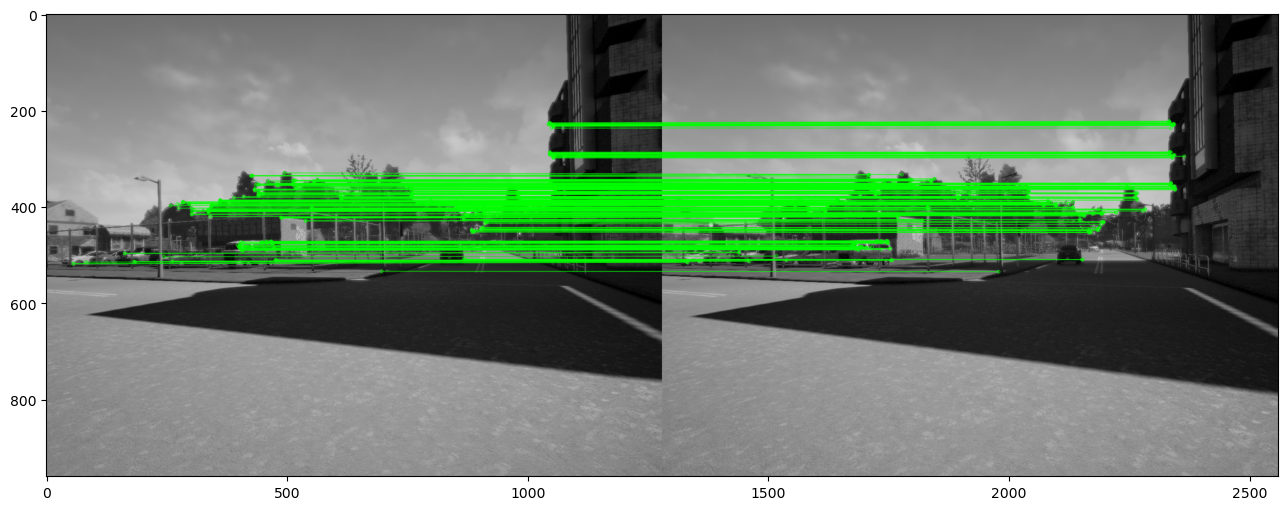

In [31]:
# Compute the inputs for PnP
i = 0 # index of image
N = 1000 # max number of points
image1_grey = dataset_handler.images[i]
image2_grey = dataset_handler.images[i+1]
kp1 = KP_LIST[i]
kp2 = KP_LIST[i+1]
match = MATCHES[i]
depth1 = dataset_handler.depth_maps[i]

objectPoints1 = np.zeros((N,3), np.float32)
imagePoints2 = np.zeros((N,2), np.float32)

# Checkout the indices of keypoints matched
for i, m in enumerate(match[0:N]):
    
    # Fill the 3D vector of frame k-1
    col1 = kp1[m.queryIdx].pt[0]
    row1 = kp1[m.queryIdx].pt[1]
    z1 = depth1[int(row1), int(col1)]
    x1 = (col1 - K_CX) * z1 / K_FX
    y1 = (row1 - K_CY) * z1 / K_FY
    objectPoints1[i,0] = x1
    objectPoints1[i,1] = y1
    objectPoints1[i,2] = z1

    # Fill the 2D vector of frame k
    col2 = kp2[m.trainIdx].pt[0]
    row2 = kp2[m.trainIdx].pt[1]
    imagePoints2[i,0] = col2
    imagePoints2[i,1] = row2

    #print(f"i={i} -> distance: {m.distance}, p1 pixels: {col1,row1}, p2 pixels: {col2,row2}, p1 [m]: {x1,y1,z1}")

# Find the rotation and translation vectors.
output = cv2.solvePnPRansac(objectPoints1, imagePoints2, dataset_handler.k, None, useExtrinsicGuess = False, flags=cv2.SOLVEPNP_ITERATIVE)
success = output[0]
if success:
    rotation_vector = output[1]
    rotation_matrix = cv2.Rodrigues(rotation_vector)[0]
    translation_vector = output[2]
print(translation_vector)
print(rotation_matrix)

# Visualize the match
visualize_matches(image1_grey, kp1, image2_grey, kp2, match[0:N])

del i, image1_grey, kp1, image2_grey, kp2, match, m, objectPoints1, imagePoints2, col1, row1, x1,y1,z1, col2,row2, output, success, rotation_vector, rotation_matrix, translation_vector, N

rotation matrix:
[[ 9.99633443e-01 -2.34603105e-02 -1.35126931e-02]
 [ 2.34572522e-02  9.99724767e-01 -3.84802287e-04]
 [ 1.35180016e-02  6.76905848e-05  9.99908625e-01]]
translation vector:
[[ 0.10009157]
 [ 0.06210247]
 [-0.42127143]]


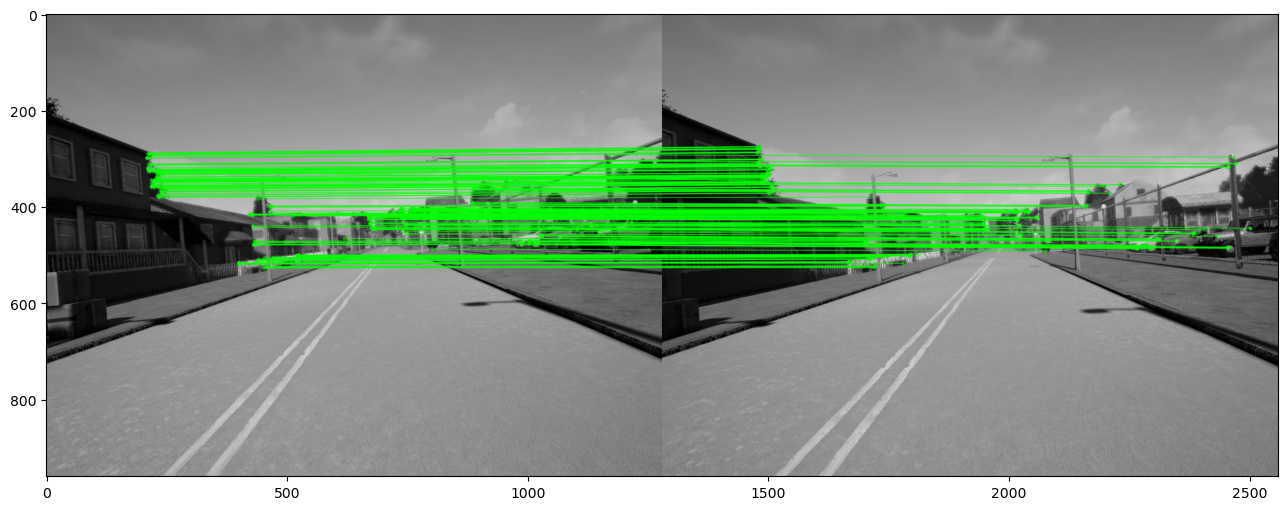

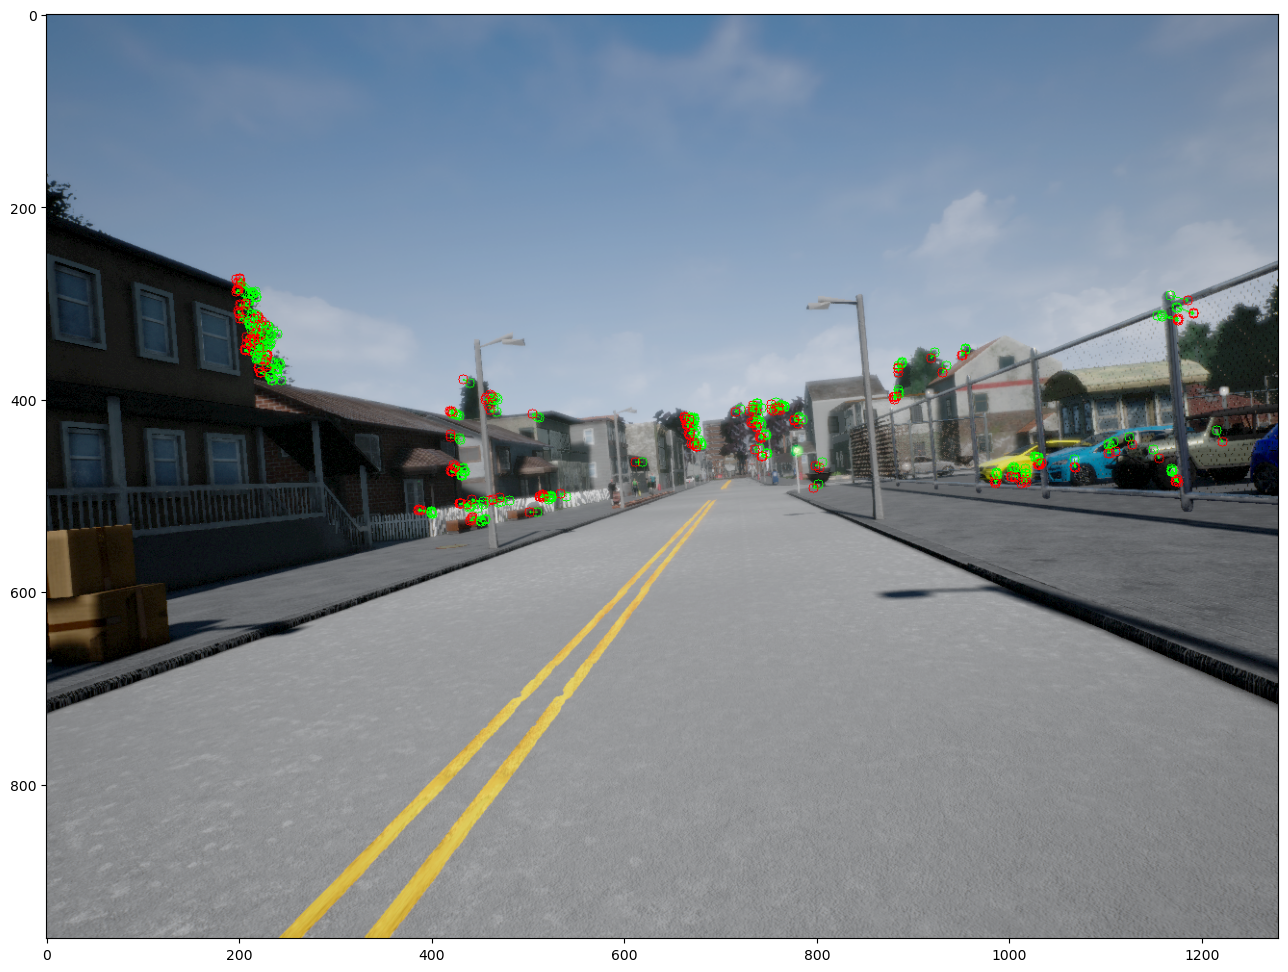

In [42]:
def estimate_motion(match:list, kp1: list, kp2: list, k: np.ndarray, depth1: np.ndarray):
    """
    Estimate camera motion from a pair of subsequent image frames
    (I am going to use PnP+Ransac)

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera calibration matrix 
    depth1 -- a depth map of the first frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    rmat -- recovered 3x3 rotation numpy matrix
    tvec -- recovered 3x1 translation numpy vector
    image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
    image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
               
    """
    # Source: https://betterprogramming.pub/point-cloud-computing-from-rgb-d-images-918414d57e80

    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    image1_points = []
    image2_points = []
    
    ### START CODE HERE ###
    N = len(match)
    objectPoints1 = np.zeros((N,3), np.float32)
    imagePoints2 = np.zeros((N,2), np.float32)
    
    for i, m in enumerate(match):
    
        # Fill the 3D vector of frame k-1
        col1 = kp1[m.queryIdx].pt[0]
        row1 = kp1[m.queryIdx].pt[1]
        image1_points.append((col1, row1))
        z1 = depth1[int(row1), int(col1)]
        x1 = (col1 - K_CX) * z1 / K_FX
        y1 = (row1 - K_CY) * z1 / K_FY
        objectPoints1[i,0] = x1
        objectPoints1[i,1] = y1
        objectPoints1[i,2] = z1

        # Fill the 2D vector of frame k
        col2 = kp2[m.trainIdx].pt[0]
        row2 = kp2[m.trainIdx].pt[1]
        image2_points.append((col2, row2))
        imagePoints2[i,0] = col2
        imagePoints2[i,1] = row2

    # Find the rotation and translation vectors.
    output = cv2.solvePnPRansac(objectPoints1, imagePoints2, dataset_handler.k, None, useExtrinsicGuess = False, flags=cv2.SOLVEPNP_ITERATIVE)
    success = output[0]
    if success:
        rotation_vector = output[1]
        rmat = cv2.Rodrigues(rotation_vector)[0]
        tvec = output[2].reshape(3,1)
    
    ### END CODE HERE ###    
    return rmat, tvec, image1_points, image2_points

# Unit test
i = 45
kp1 = KP_LIST[i]
kp2 = KP_LIST[i+1]
match = MATCHES[i]
depth1 = dataset_handler.depth_maps[i]

# Compute function
rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, dataset_handler.k, depth1)
print(f"rotation matrix:\n{rmat}")
print(f"translation vector:\n{tvec}")

# Visualize the match
image1_grey = dataset_handler.images[i]
image2_grey = dataset_handler.images[i+1]
visualize_matches(image1_grey, kp1, image2_grey, kp2, match)

# Visualize image movement
# These visualizations might be helpful for understanding the quality of image points selected for the camera motion estimation
img1_rgb = dataset_handler.images_rgb[i]
img2_rgb = dataset_handler.images_rgb[i+1]
image_move = visualize_camera_movement(img1_rgb, image1_points, img2_rgb, image2_points, is_show_img_after_move=False)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)

del i, kp1, kp2, match, depth1, rmat, tvec, image1_points, image2_points, image1_grey, image2_grey, image_move

**Expected Output Format**:

Make sure that your estimated rotation matrix and translation vector are in the same format as the given initial values

```
rmat = np.eye(3)
tvec = np.zeros((3, 1))

print("Initial rotation:\n {0}".format(rmat))
print("Initial translation:\n {0}".format(tvec))
```


```
Initial rotation:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Initial translation:
 [[0.]
 [0.]
 [0.]]
```

**Camera Movement Visualization**:
You can use `visualize_camera_movement` that is provided to you. This function visualizes final image matches from an image pair connected with an arrow corresponding to direction of camera movement (when `is_show_img_after_mov = False`). The function description:
```
Arguments:
image1 -- the first image in a matched image pair (RGB or grayscale)
image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [x, y], where x and y are 
                 coordinates of the i-th match in the image coordinate system
image2 -- the second image in a matched image pair (RGB or grayscale)
image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [x, y], where x and y are 
                 coordinates of the i-th match in the image coordinate system
is_show_img_after_mov -- a boolean variable, controling the output (read image_move description for more info) 

Returns:
image_move -- an image with the visualization. When is_show_img_after_mov=False then the image points from both images are visualized on the first image. Otherwise, the image points from the second image only are visualized on the second image
```

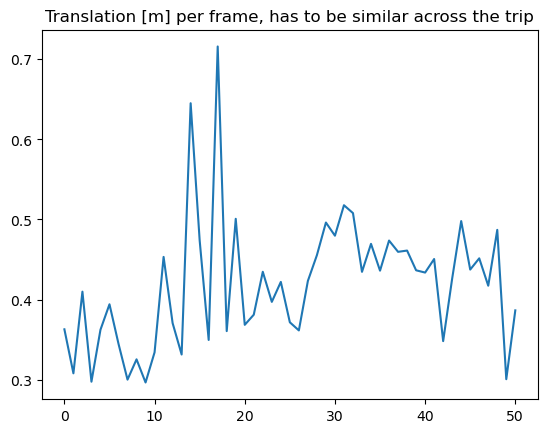

In [51]:
# Compute all results in translation and rotation
ROTATIONS = []
TRANSLATIONS = []
for i in range(dataset_handler.num_frames-1):   # the last frame does not get computed
    #print(f"i={i}")
    kp1 = KP_LIST[i]                            # keypoints of frame i
    kp2 = KP_LIST[i+1]                          # keypoints of frame i+1
    match = MATCHES[i]                          # matches of kp from i and i+1
    depth1 = dataset_handler.depth_maps[i]      # depth map of frame i
    rotation, translation, _, _ = estimate_motion(match, kp1, kp2, dataset_handler.k, depth1)
    ROTATIONS.append(np.asarray(rotation))
    TRANSLATIONS.append(np.asarray(translation))
    #print(f"R:\n{rotation}")
    #print(f"t:\n{translation}\n")

translation_distance = [np.linalg.norm(t) for t in TRANSLATIONS]
plt.plot(translation_distance)
plt.title("Translation [m] per frame, has to be similar across the trip")
plt.show()

### 3.2 - Camera Trajectory Estimation

**Task**: Implement camera trajectory estimation with visual odometry. More specifically, implement camera motion estimation for each subsequent image pair in the dataset with the function you wrote in the above section.

***Note***: Do not forget that the image pairs are not independent one to each other. i-th and (i + 1)-th image pairs have an image in common

In [64]:
len(ROTATIONS)

51

In [94]:
def estimate_trajectory(rotations:list, translations:list):
    """
    Estimate complete camera trajectory from subsequent image pairs

    Arguments:
    rotations (list of 3x3 np.ndarray):      rot matrix from each frame from i to i+1
    translations (list of 3x1 np.ndarray):   translation vector from each frame i to i+1
    
    Returns:
    trajectory -- a 3xlen numpy array of the camera locations, where len is the lenght of the list of images and   
                  trajectory[:, i] is a 3x1 numpy vector, such as:
                  
                  trajectory[:, i][0] - is X coordinate of the i-th location
                  trajectory[:, i][1] - is Y coordinate of the i-th location
                  trajectory[:, i][2] - is Z coordinate of the i-th location
                  
                  * Consider that the origin of your trajectory cordinate system is located at the camera position 
                  when the first image (the one with index 0) was taken. The first camera location (index = 0) is given 
                  at the initialization of this function

    """
    assert len(rotations) == len(translations)
    N = len(rotations)
    trajectory = np.zeros((3, N+1)) # starts at (0,0,0)
    initial_pos_camera = np.asarray([0,0,0,1]) # we are using homogeneous coordinates
    current_inverse = np.eye(4)
    for i in range(1, N + 1):
        # This is the transformation to go from cam frame i-1 to i
        R_t = np.eye(4)
        R_t[0:3,0:3] = rotations[i-1]                 # this is the rotation
        R_t[0:3,3] = translations[i-1].reshape(3,)    # this is the translation
        R_t_inv = np.linalg.inv(R_t)
        current_inverse = np.dot(current_inverse, R_t_inv)        
        new_position = np.dot(current_inverse, initial_pos_camera)
        new_position = new_position / new_position[3] # homogeneize, this is (4,)
        trajectory[:,i] = new_position[0:3]
        
    ### END CODE HERE ###    
    return trajectory

# Unit test
trajectory = estimate_trajectory(ROTATIONS, TRANSLATIONS)
print(trajectory.shape)

(3, 52)


**Expected Output**:

```
Camera location in point i is: 
 [[locXi]
 [locYi]
 [locZi]]```
 
 In this output: locXi, locYi, locZi are the coordinates of the corresponding i-th camera location

## 4 - Submission:

Evaluation of this assignment is based on the estimated trajectory from the output of the cell below.
Please run the cell bellow, then copy its output to the provided yaml file for submission on the programming assignment page.

**Expected Submission Format**:

```
Trajectory X:
 [[  0.          locX1        locX2        ...   ]]
Trajectory Y:
 [[  0.          locY1        locY2        ...   ]]
Trajectory Z:
 [[  0.          locZ1        locZ2        ...   ]]
```
 
 In this output: locX1, locY1, locZ1; locX2, locY2, locZ2; ... are the coordinates of the corresponding 1st, 2nd and etc. camera locations

In [95]:
# Note: Make sure to uncomment the below line if you modified the original data in any ways
#dataset_handler = DatasetHandler()

# Part 1. Features Extraction
#images = dataset_handler.images
#kp_list, des_list = extract_features_dataset(images, extract_features)

# Part II. Feature Matching
#matches = match_features_dataset(des_list, match_features)

# Set to True if you want to use filtered matches or False otherwise
#is_main_filtered_m = True
#if is_main_filtered_m:
#    dist_threshold = 0.75
#    filtered_matches = filter_matches_dataset(filter_matches_distance, matches, dist_threshold)
#    matches = filtered_matches
    
# Part III. Trajectory Estimation
#depth_maps = dataset_handler.depth_maps
#trajectory = estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=depth_maps)


#!!! Make sure you don't modify the output in any way
# Print Submission Info
print("Trajectory X:\n {0}".format(trajectory[0,:].reshape((1,-1))))
print("Trajectory Y:\n {0}".format(trajectory[1,:].reshape((1,-1))))
print("Trajectory Z:\n {0}".format(trajectory[2,:].reshape((1,-1))))

Trajectory X:
 [[ 0.00000000e+00  5.27011364e-03  3.08641748e-02  1.19162983e-01  1.63644515e-01  1.60717723e-01  1.46432434e-01  1.40569570e-01  1.04146506e-01  1.29729072e-01  1.29166049e-01  1.09783558e-01  3.51026712e-02 -2.61893140e-02 -1.16559748e-01 -3.68265833e-01 -5.40168987e-01 -6.67727924e-01 -8.97000486e-01 -1.01217840e+00 -1.18766648e+00 -1.34576009e+00 -1.52853723e+00 -1.74943294e+00 -1.97494390e+00 -2.22682378e+00 -2.41963903e+00 -2.59502208e+00 -2.80066826e+00 -3.04426980e+00 -3.31971805e+00 -3.60998082e+00 -3.94509905e+00 -4.31686897e+00 -4.68987637e+00 -5.08686784e+00 -5.50354547e+00 -5.93870590e+00 -6.38624011e+00 -6.84114829e+00 -7.27486748e+00 -7.70724545e+00 -8.15404366e+00 -8.49944579e+00 -8.92504874e+00 -9.42147150e+00 -9.85516727e+00 -1.02814199e+01 -1.06928318e+01 -1.11299605e+01 -1.14105575e+01 -1.17328462e+01]]
Trajectory Y:
 [[ 0.         -0.02192056 -0.03932021 -0.09054486 -0.11412398 -0.1124048  -0.12795684 -0.14869443 -0.14171959 -0.17180572 -0.19005637 

### Visualize your Results

**Important**:

1) Make sure your results visualization is appealing before submitting your results. You might want to download this project dataset and check whether the trajectory that you have estimated is consistent to the one that you see from the dataset frames. 

2) Assure that your trajectory axis directions follow the ones in _Detailed Description_ section of [OpenCV: Camera Calibration and 3D Reconstruction](https://docs.opencv.org/3.4.3/d9/d0c/group__calib3d.html).

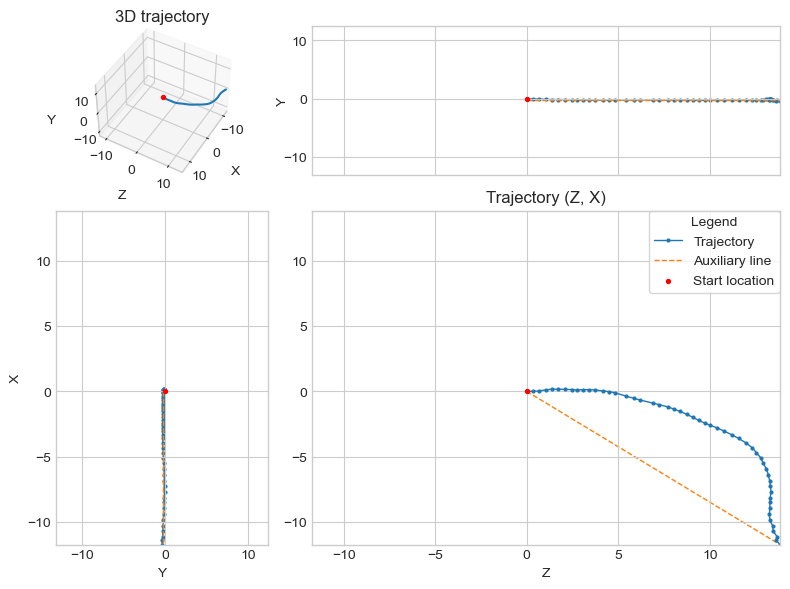

In [96]:
visualize_trajectory(trajectory)

In [98]:
# Build the point cloud of an image and its depth [m]
i = 0
depth1 = dataset_handler.depth_maps[i]

pcd = []
MAX_DEPTH = 200
H,W = depth1.shape
for i in range(H):
   for j in range(W):
       z = depth1[i][j]
       if z < MAX_DEPTH:
        x = (j - K_CX) * z / K_FX
        y = (i - K_CY) * z / K_FY
        pcd.append([x, y, z])

# Display it with Open3D
# http://www.open3d.org/docs/release/python_api/open3d.geometry.TriangleMesh.html
# X = RED
# Y = GREEN
# Z = BLUE
pcd_o3d = o3d.geometry.PointCloud()  # create point cloud object
pcd_o3d.points = o3d.utility.Vector3dVector(pcd)  # set pcd_np as the point cloud points

pcd_trajectory = o3d.geometry.PointCloud()
pcd_trajectory.points = o3d.utility.Vector3dVector(trajectory.T)# trajectory.T this is [N,3] with the order x,y,z for each row
pcd_trajectory.paint_uniform_color([0,0,0])

# Visualize:
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=30)
mesh_frame.translate([0,0,0])
o3d.visualization.draw_geometries([pcd_o3d, mesh_frame, pcd_trajectory])

del pcd, MAX_DEPTH, H, W, i, j, z, x, y, pcd_o3d, mesh_frame, pcd_trajectory